<a href="https://colab.research.google.com/github/cheonghf/ML-P4-03/blob/main/Project_SourceCode_P4_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

dataset_1 = 'https://raw.githubusercontent.com/cheonghf/ML-P4-03/refs/heads/main/bank_transactions_data_2.csv'

bt_df1 = pd.read_csv(dataset_1, index_col = 0) #retrive address with pandas to form banktransactions_dataframe1

Display the first 5 rows of the dataset

In [ ]:
bt_df1.head()

Display the last 5 rows of the dataset

In [ ]:
bt_df1.tail()

Understanding the Number of (Rows, Columns)

In [ ]:
bt_df1.shape

Understanding the Data Type in the DataFrame

In [ ]:
bt_df1.dtypes

Previewing of Column Labels in DataFrame

In [ ]:
bt_df1.columns

Understand if there is any null or missing data in the dataframe.


In [ ]:
bt_df1.isnull().sum(axis=0)

Understand the numerical value in DataFrame via statistic

In [ ]:
bt_df1.describe()

Understand the amount of Unique in Column 'Channel' of DataFrame

In [ ]:
bt_df1.Channel.value_counts()

#RUN: We plan to focus on 'Online' and Calculate the percentage of each Online Transactions against the Account Balance to detect fraud











In [ ]:
df_online = bt_df1[bt_df1['Channel'] == 'Online'] #Filter the DataFrame for transactions where the Channel is 'Online'

df_online_trans_percentage =  (df_online['TransactionAmount'] / (df_online['TransactionAmount'] + df_online['AccountBalance'])) * 100 #Calculation of OnlineTransactionPercentage

df_online_diff = pd.DataFrame(df_online["TransactionAmount"] >= df_online["AccountBalance"]) #Return True to DataFrame Online Difference if TransactionAmount greater or equal to AccountBalance

df_online_cleaned = df_online.loc[:, ['AccountID','LoginAttempts','TransactionDuration','CustomerAge']] #Filter only the required column and values

df_online_cleaned['OnlineTransactionPercentage'] = df_online_trans_percentage #Insert Calculated OnlineTransactionPercentage

df_online_cleaned['OnlineTransactionDifference'] = df_online_diff #Insert OnlineTransactionDifference

df_online_cleaned = df_online_cleaned.set_index('AccountID', drop = False) #Set Index Label to 'AccountID'

print(df_online_cleaned)


Understand how many Online Transacation Amount is NOT Larger or Equal to AccountBalance in the DataFrame of Online Difference

In [ ]:
df_online_diff.describe()

Understand CustomerAge statistic for OnlineTransactions

In [ ]:
df_online['CustomerAge'].describe()

Understand each category (min to max) of total number of LoginAttempts in the DataFrame of Online Cleaned

In [ ]:
for x in range (1,6):
  count_x = df_online_cleaned['LoginAttempts'].value_counts().get(x)
  print("Occurrences of LoginAttempts", x ,":", count_x)

Understand the number of unique AccountID in DataFrame of Online Cleaned

In [ ]:
df_online_cleaned.AccountID.unique().size

Show correlation Heat Map and Matrix

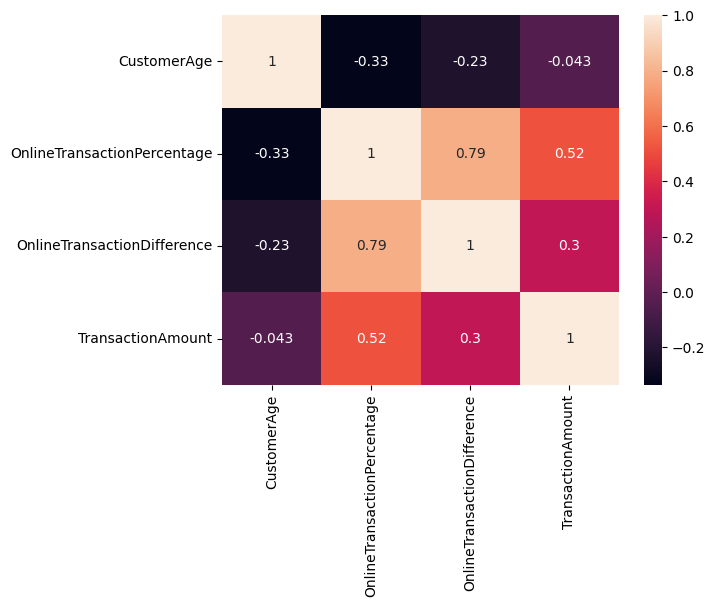

In [ ]:
df_online_cleaned_corr = df_online_cleaned.get(['CustomerAge', 'OnlineTransactionPercentage','OnlineTransactionDifference', 'TransactionAmount'])

corrmat = df_online_cleaned_corr.corr()

sns.heatmap(corrmat,annot = True)
plt.show()

#RUN: Feed the required data into the Logistic Regression Model for Binary Classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = df_online_cleaned.loc[:, ['OnlineTransactionPercentage', 'TransactionAmount']]
y = df_online_cleaned['OnlineTransactionDifference']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=1)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

#RUN: Prediction, Accuracy Score, Confusion Matrix & Classification Report

Accuracy of the binary classifier = 0.988



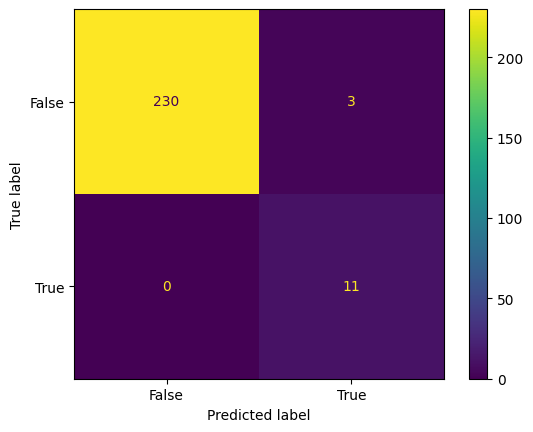


Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.99      0.99       233
        True       0.79      1.00      0.88        11

    accuracy                           0.99       244
   macro avg       0.89      0.99      0.94       244
weighted avg       0.99      0.99      0.99       244



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC

# Predict on Test Data
y_pred = model.predict(X_test)

# Evaluate accuracy of the model, (TP + TN) / (TP + FP + TN + FN)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy))

print()

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

print()

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

ROC Curve & AUC Score (May be wrong, need look into this if we want to keep this)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get probability scores
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#RUN: Hyperparameter Tuning the Model for Better Performance

Logistic Regression has parameters like C (regularization). We can tune them using Grid Search.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Run GridSearchCV
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 0.01}


#RUN: Retrain the model

In [ ]:
# Get the best parameter
best_C = grid_search.best_params_['C']

# Train the final model with the best parameters
final_model = LogisticRegression(C=best_C, random_state=1)
final_model.fit(X_train, y_train)


LogisticRegression(C=0.01, random_state=1)

#RUN: Final Prediction, Final Accuracy Score, Final Confusion Matrix & Final Classification Report

Final Model Accuracy: 0.996



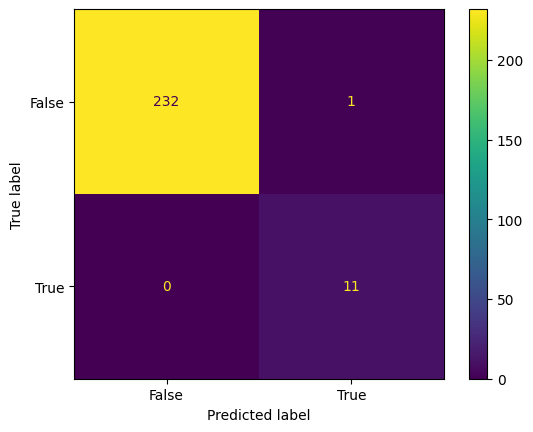


Final Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       233
        True       0.92      1.00      0.96        11

    accuracy                           1.00       244
   macro avg       0.96      1.00      0.98       244
weighted avg       1.00      1.00      1.00       244



In [ ]:
# Predict on test data
y_final_pred = final_model.predict(X_test)

# Print accuracy
final_accuracy = accuracy_score(y_test, y_final_pred)
print(f'Final Model Accuracy: {final_accuracy:.3f}')

print()

# Print confusion matrix
cm = confusion_matrix(y_test, y_final_pred)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
cm = confusion_matrix(y_test, y_final_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

print()

# Print classification report
print("Final Classification Report:\n", classification_report(y_test, y_final_pred))

#RUN: Save the Trained Logistic Regression Binary Class Model

In [ ]:
import joblib

# Save the model
joblib.dump(final_model, 'log_reg_binaryclass_model_best.pkl')

['log_reg_binaryclass_model_best.pkl']

#RUN: Feed New Data into Final Model for Experimentation

In [ ]:
# Load model
lgr_bc_model = joblib.load('log_reg_binaryclass_model_best.pkl')

# Define feature names based on the training data
feature_names = ['OnlineTransactionPercentage', 'TransactionAmount']

# Feed New Test Data
X_new = np.array([[70,10], [80,5000], [10,1000], [55,100], [30,88]]) # Change your Numbers HERE

# Convert X_new to a pandas DataFrame with feature names
X_new_df = pd.DataFrame(X_new, columns=feature_names)

# Predict using the loaded model
new_predictions = lgr_bc_model.predict(X_new_df)

# Print new_predictions result
print("Predicted Outcome:", new_predictions)  # Output will be either 0 or 1

Predicted Class: [ True  True False  True False]


#**MISC**

In [ ]:
'''
Old Test Run
'''

bt_df1_corr = bt_df1.get(['TransactionAmount', 'CustomerAge', 'AccountBalance'])

corrmat = bt_df1_corr.corr()

sns.heatmap(corrmat,annot = True)
plt.show()